In [4]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
# ok redo with this sampling method (need to tweek it or whatever)

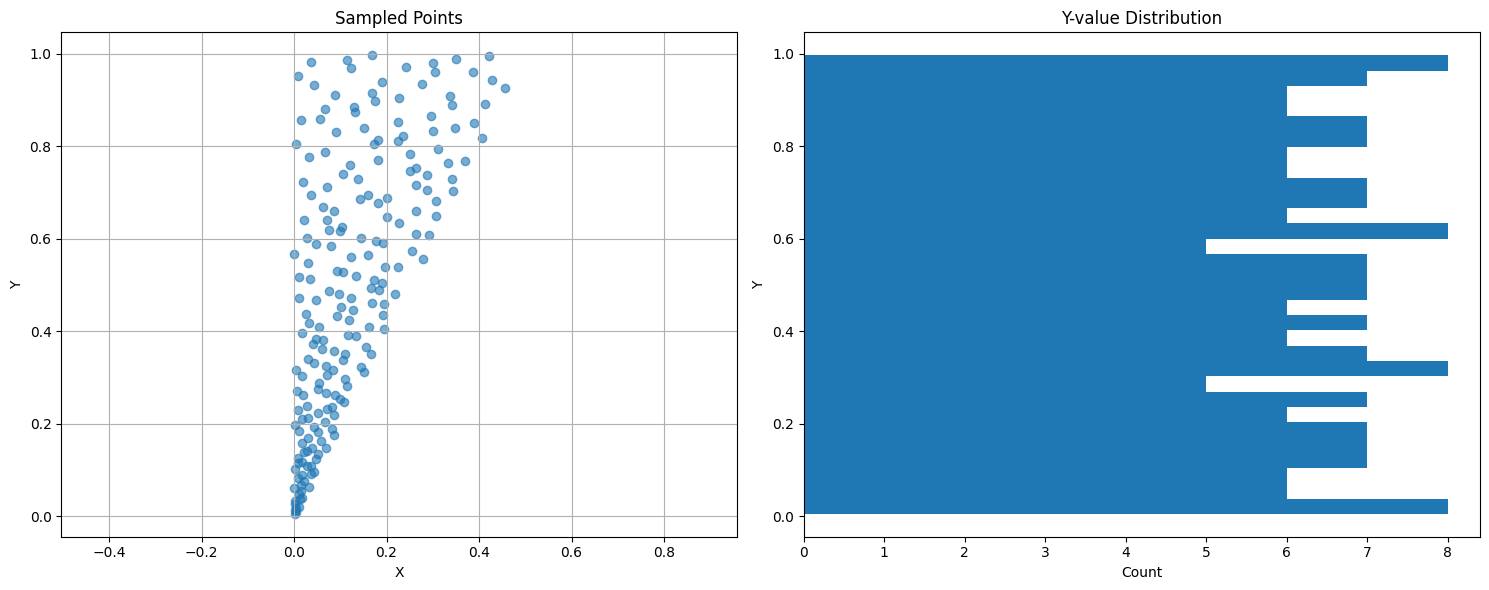

Y-value statistics:
Mean: 0.501
Std: 0.289


In [14]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def sample_triangle_uniform_y(n_points):
    """
    Generate samples in right triangle above y=x with uniform y-density.
    
    Args:
        n_points: Number of points to sample
    Returns:
        Array of sampled points with shape (n_points, 2)
    """
    # Create Sobol sampler for 2 dimensions
    sampler = qmc.Sobol(d=2, scramble=True)
    
    # Generate points in unit square
    points = sampler.random(n=n_points)
    
    # First coordinate (points[:, 0]) will be used for y
    y = points[:, 0]
    
    # For each y, x should be uniform between 0 and y / 2
    # Use points[:, 1] to interpolate between y and 1
    x = (y / 2) * points[:, 1]
    
    return np.column_stack([x, y])

# Generate points
n_points = 200
points = sample_triangle_uniform_y(n_points)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the points
ax1.scatter(points[:, 0], points[:, 1], alpha=0.6)
ax1.set_title('Sampled Points')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.axis('equal')
ax1.grid(True)

# Plot y-value histogram to show density
ax2.hist(points[:, 1], bins=30, orientation='horizontal')
ax2.set_ylabel('Y')
ax2.set_xlabel('Count')
ax2.set_title('Y-value Distribution')

plt.tight_layout()
plt.show()

# Print some statistics about y-distribution
y_values = points[:, 1]
print(f"Y-value statistics:")
print(f"Mean: {np.mean(y_values):.3f}")
print(f"Std: {np.std(y_values):.3f}")

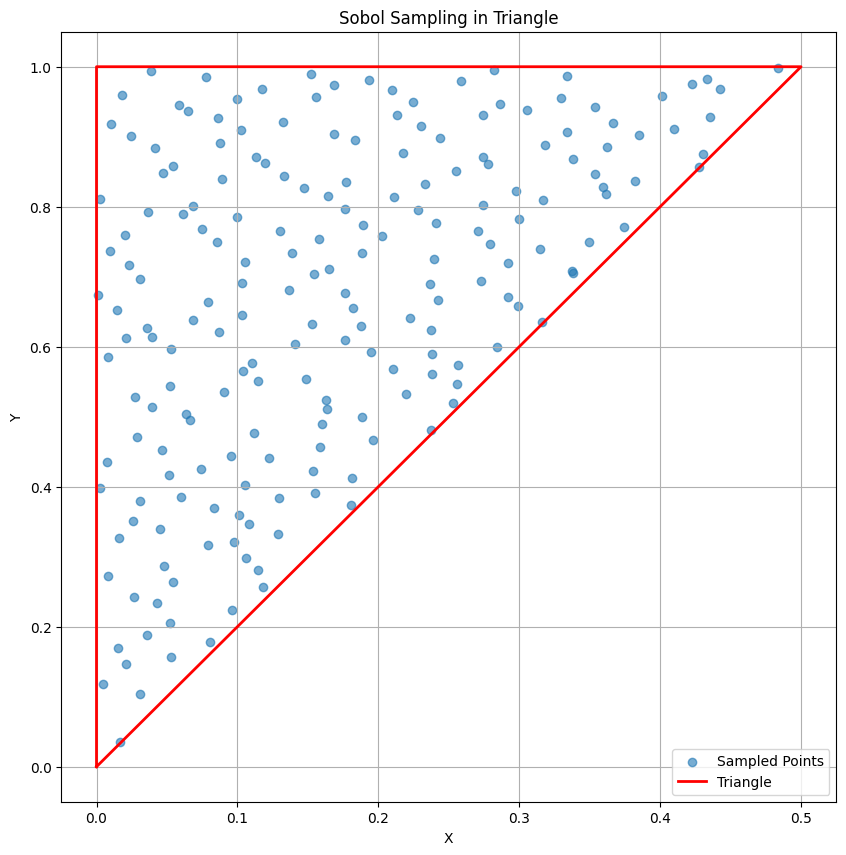

In [9]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def sample_triangle(n_points, vertices):
    """
    Generate uniform samples in a triangle using Sobol sequence.
    
    Args:
        n_points: Number of points to sample
        vertices: Array of triangle vertices with shape (3, 2)
    Returns:
        Array of sampled points with shape (n_points, 2)
    """
    # Create Sobol sampler for 2 dimensions
    sampler = qmc.Sobol(d=2, scramble=True)
    
    # Generate points in unit square
    points = sampler.random(n=n_points)
    
    # Transform to triangle using sqrt method
    sqrt_r1 = np.sqrt(points[:, 0])
    a = 1 - sqrt_r1
    b = sqrt_r1 * (1 - points[:, 1])
    c = points[:, 1] * sqrt_r1
    
    # Convert to Cartesian coordinates
    result = (vertices[0][None, :] * a[:, None] +
             vertices[1][None, :] * b[:, None] +
             vertices[2][None, :] * c[:, None])
    
    return result

# Example usage
# Define triangle vertices
triangle = np.array([
    [0, 0],    # vertex 1
    [0.5, 1],    # vertex 2
    [0, 1]   # vertex 3
])

# Generate 200 points
points = sample_triangle(200, triangle)

# Plotting
plt.figure(figsize=(10, 10))

# Plot the sampled points
plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label='Sampled Points')

# Plot the triangle
plt.plot(triangle[[0,1,2,0], 0], triangle[[0,1,2,0], 1], 
         'r-', linewidth=2, label='Triangle')

plt.title('Sobol Sampling in Triangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
# plt.axis('equal')
plt.grid(True)
plt.show()

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


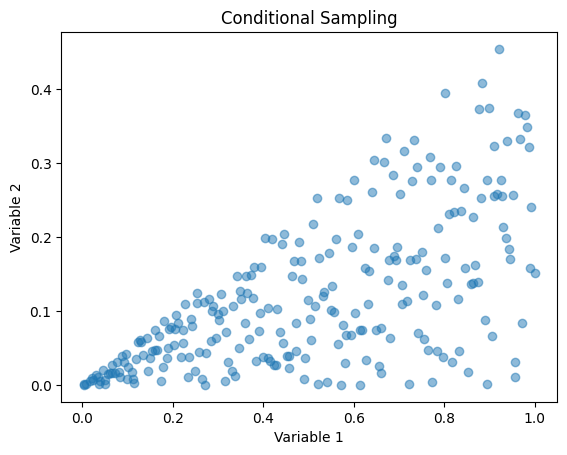

In [3]:
from scipy.stats import qmc
import numpy as np

def conditional_sobol_sampling(n_samples):
    # Initialize Sobol sampler for first variable
    sampler = qmc.Sobol(d=1)
    
    # Generate Sobol samples for first variable
    var1 = sampler.random(n=n_samples).flatten()
    
    # Initialize result array
    result = np.zeros((n_samples, 2))
    result[:, 0] = var1
    
    # Generate conditional samples for second variable
    result[:, 1] = np.random.uniform(0, var1/2)
    
    return result

# Example usage
samples = conditional_sobol_sampling(250)

# Visualization
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title('Conditional Sampling')
plt.show()

In [5]:
OUT_DIR = Path("output/mix_rate_lb_sweep/2025-02-19_03-34-58")

In [ ]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = ["toy_grid", "fmnist_mnist", "cifar_mnist", "waterbirds"]

In [ ]:
def get_study_name(ds_name, mix_rate):
    return f"{ds_name}_{mix_rate}"

In [7]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
import json
import yaml
import pandas as pd
import numpy as np
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(OUT_DIR).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        if not metric_file.exists(): 
            print(f"No metrics file found for {exp_dir}")
            continue
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])

        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        max_source_acc = max(source_acc_0, source_acc_1)

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)

No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/146
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/145
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/142
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/148
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/147
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/149
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/143
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/150
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.5/144
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.1/137
No metrics file found for output/mix_rate_lb_sweep/2025-02-19_03-34-58/waterbirds_0.1/129
No metrics

In [18]:
def plot_mix_rate_accuracy(df, dataset, mix_rate, figsize=(10, 8), vmin=0.5, vmax=1.0):
    """
    Plot scatter of max source accuracy for given dataset and mix rate.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to plot
        mix_rate: float, mix rate to plot
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        data['mix_rate_lb_01'], 
        data['mix_rate_lb_01'] + data['mix_rate_lb_10'], 
        c=data['source_acc'],
        cmap='viridis',
        vmin=vmin,  # Set minimum value for color scale
        vmax=vmax,  # Set maximum value for color scale
        s=100  # Point size
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Max Source Accuracy')
    
    # Labels and title
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'Max Source Accuracy\nDataset: {dataset}, Mix Rate: {mix_rate}')
    
    # plt.tight_layout()
    plt.show()

In [17]:
# get max mix rate lb 01 for each dataset 
df.groupby('dataset')['mix_rate_lb_01'].max()

dataset
cifar_mnist     0.314943
fmnist_mnist    0.478141
toy_grid        0.478244
waterbirds      0.478141
Name: mix_rate_lb_01, dtype: float64

In [16]:
# get number of trials in each dataset mix rate combo 
df.groupby(['dataset', 'mix_rate']).size()

dataset       mix_rate
cifar_mnist   0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
fmnist_mnist  0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
toy_grid      0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
waterbirds    0.10        129
              0.25        141
              0.50        142
              0.75         56
dtype: int64

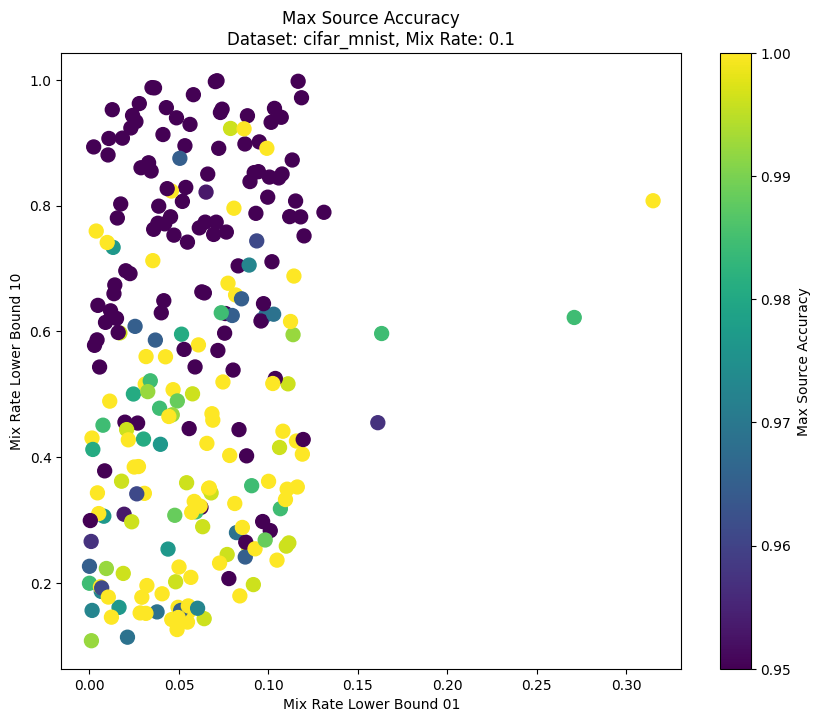

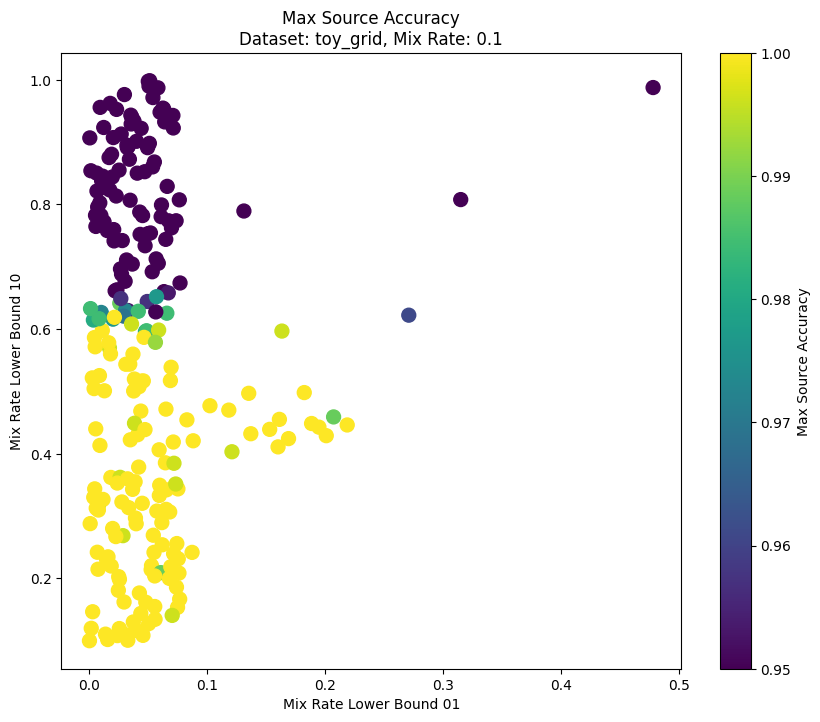

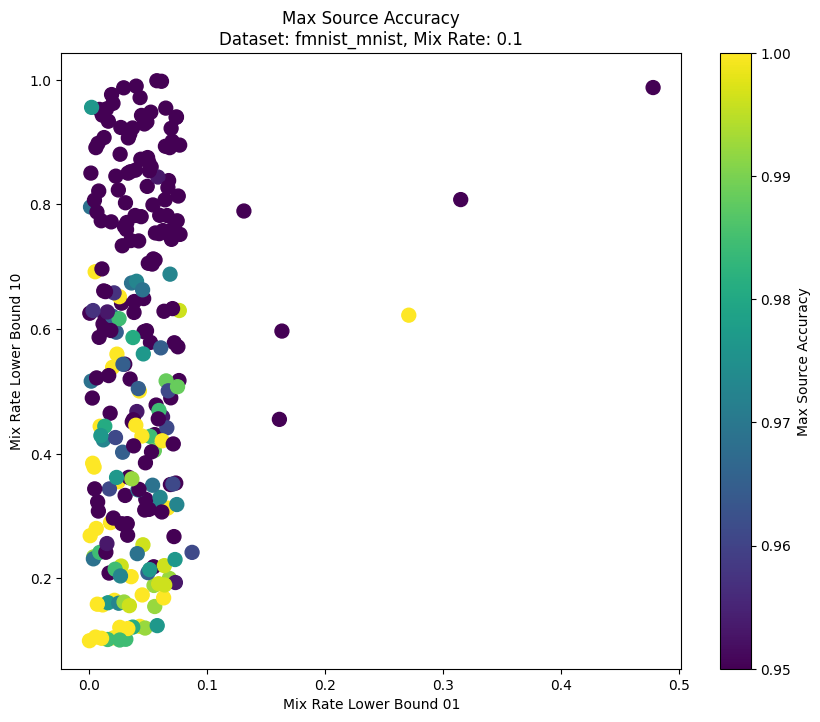

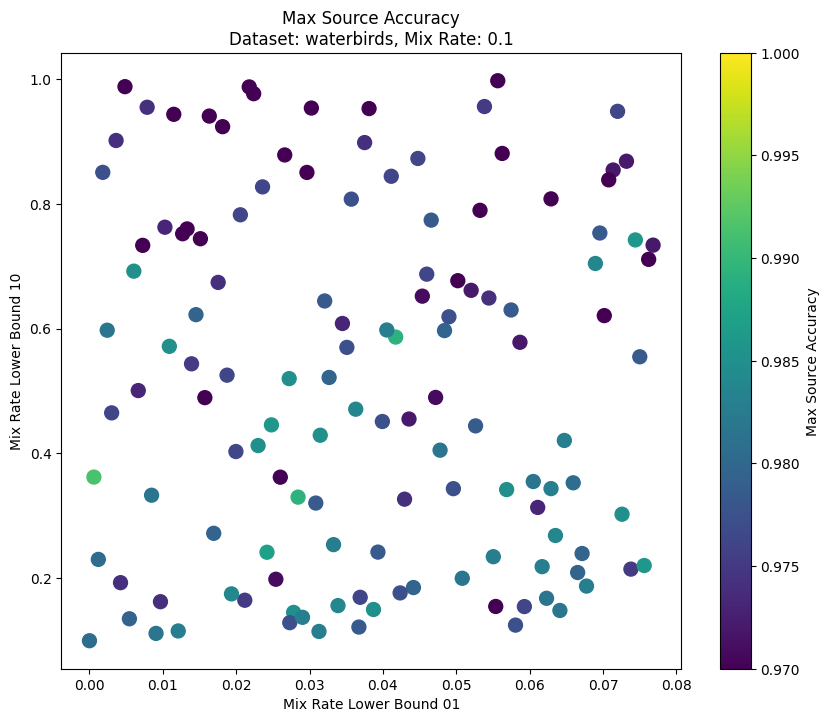

In [24]:
# Example usage:
mix_rate = 0.1
vmin = 0.95
vmax = 1.0
plot_mix_rate_accuracy(df, dataset='cifar_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='toy_grid', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='fmnist_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='waterbirds', mix_rate=mix_rate, vmin=0.97, vmax=1.0)